# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np

/home/ddallo/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 3 Device 22 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 121 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 118 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 120 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 84 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 34 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 87 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [273]:
schip = score = 0
sid = 200
chip = core_e = 0
core_i = 1

duration = 2

neuron_ids_E1 = np.arange(1,9)
neuron_ids_I1 = neuron_ids_E1
neuron_ids_E2 = neuron_ids_E1 + neuron_ids_E1.size
neuron_ids_I2 = neuron_ids_E2

# init a network generator
net = network.DynapseNetworkGenerator()

spikegen = net.get_spikegen(schip, score, sid)
neurons_E1 = net.get_neurons(chip, core_e, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)

net.add_connections_one_to_all(spikegen, neurons_E1, network.SYNAPSE_AMPA, weight=12)
net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=1)

net.add_connections_one_to_all(spikegen, neurons_E2, network.SYNAPSE_AMPA, weight=12)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=1)
# coupling
net.add_connections_all_to_all(neurons_E1, neurons_E2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_E2, neurons_E1, network.SYNAPSE_GABA_B)
# net.add_connections_all_to_all(neurons_I1, neurons_E2, network.SYNAPSE_AMPA)
# net.add_connections_all_to_all(neurons_I2, neurons_E1, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons_E1 + neurons_E2 + neurons_I1 + neurons_I2)
# dynapse.monitor_neuron_network(neurons_E1 + neurons_I1)

model.apply_configuration(net.get_config())

poisson_gen = dynapse.get_poisson_spikegen(20, schip, score, sid)

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [217]:
# set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.NEURON_TIME_CONSTANT_1, (4,80), chip, core_e)
parameters.set_param(model, parameters.NEURON_TIME_CONSTANT_1, (4,80), chip, core_i)

parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core_e)
parameters.set_param(model, parameters.GABA_B_TIME_CONSTANT, (4,80), chip, core_e)
parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core_i)

parameters.set_param(model, parameters.AMPA_WEIGHT, (6,50), chip, core_e)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (0,0), chip, core_e)
parameters.set_param(model, parameters.AMPA_WEIGHT, (6,20), chip, core_i)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (0,0), chip, core_i)
# base E @ 35 Hz, I @ 15 Hz

parameters.set_param(model, parameters.AMPA_WEIGHT, (6,40), chip, core_e)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (5,160), chip, core_e)
parameters.set_param(model, parameters.AMPA_WEIGHT, (5,55), chip, core_i)

8627451.0

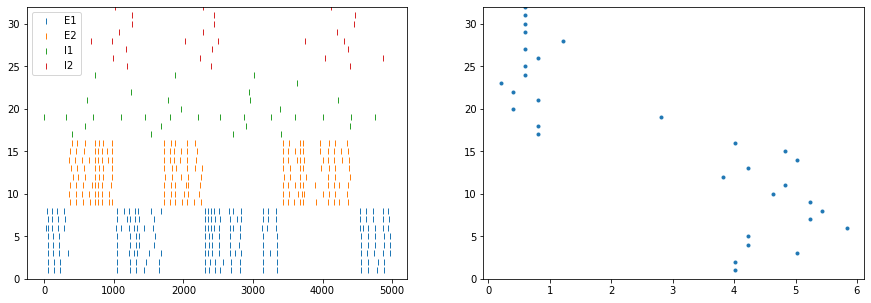

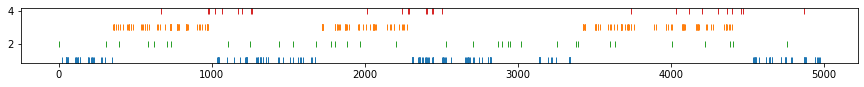

Firing rate e1 = 1.001630654705861 Hz
Firing rate e2 = 0.770413650497225 Hz


In [274]:
poisson_gen.start()
dynapse.start_graph()
dynapse.run_simulation(0.1) # bug with clearing the buffer at the moment - need to run the simulation for a little bit to do so
spikes = dynapse.run_simulation(5)
dynapse.stop_graph()
poisson_gen.stop()

spikes_array = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes_array[:,0] -= spikes_array[0,0]

exc_spikes = spikes_array[spikes_array[:,1] < 256,:]
inh_spikes = spikes_array[spikes_array[:,1] >= 256,:]
e1 = exc_spikes[exc_spikes[:,1] <= neuron_ids_E1.size,:]
e2 = exc_spikes[exc_spikes[:,1] > neuron_ids_E1.size,:]
i1 = inh_spikes[inh_spikes[:,1]-256 <= neuron_ids_I1.size,:]
i2 = inh_spikes[inh_spikes[:,1]-256 > neuron_ids_I1.size,:]

neuron_indices = np.hstack((neuron_ids_E1,neuron_ids_E2,neuron_ids_I1+256,neuron_ids_I2+256))
rates = np.array([np.count_nonzero(spikes_array[:,1] == neuron_index) for neuron_index in neuron_indices]) / (spikes_array[-1,0] - spikes_array[0,0]) * 1000000

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(e1[:,0]/1000, e1[:,1], '|', label='E1')
axs[0].plot(e2[:,0]/1000, e2[:,1], '|', label='E2')
axs[0].plot(i1[:,0]/1000, -256+2*neuron_ids_I1.size+i1[:,1], '|', label='I1')
axs[0].plot(i2[:,0]/1000, -256+2*neuron_ids_I1.size+i2[:,1], '|', label='I2')
axs[0].legend()
axs[1].plot(rates, np.arange(1,1+len(neuron_indices)), '.')
axs[0].set_ylim([0,32])
axs[1].set_ylim([0,32])
plt.show()

fig, ax = plt.subplots(1,1,figsize=(15,1))
ax.plot(e1[:,0]/1000, np.ones_like(e1[:,0]), '|', label='E1')
ax.plot(e2[:,0]/1000, 3*np.ones_like(e2[:,0]), '|', label='E2')
ax.plot(i1[:,0]/1000, 2*np.ones_like(i1[:,0]), '|', label='I1')
ax.plot(i2[:,0]/1000, 4*np.ones_like(i2[:,0]), '|', label='I2')
plt.show()

end_of_pulse_e1 = e1[np.where(np.diff(e1[:,0] / 1000) > 200), 0][0] / 1000
end_of_pulse_e2 = e2[np.where(np.diff(e2[:,0] / 1000) > 200), 0][0] / 1000
print(f'Firing rate e1 = {1000 * (len(end_of_pulse_e1) - 1) / (end_of_pulse_e1[-1]-end_of_pulse_e1[0])} Hz')
print(f'Firing rate e2 = {1000 * (len(end_of_pulse_e2) - 1) / (end_of_pulse_e2[-1]-end_of_pulse_e2[0])} Hz')

In [6]:
import time
import cv2
from IPython.display import clear_output

In [ ]:
poisson_gen.start()
dynapse.start_graph()

for i in range(100):
    spikes = dynapse.sink_node.get_buf()
    spike_ids = np.array([1024*spike.chip_id+256*spike.core_id+spike.neuron_id for spike in spikes])
    spiking_neurons = np.unique(spike_ids)
    rates = np.array([np.count_nonzero(spike_ids == neuron_index) for neuron_index in spiking_neurons])
    img = np.zeros(1024)
    if len(spikes) > 0:
        img[spike_ids] = rates
    plt.imshow(np.reshape(img,(32,32)))
    plt.title(str(i))
    plt.show()
    clear_output(wait=True)

dynapse.stop_graph()
poisson_gen.stop()


Error: Session cannot generate requests

In [ ]:
poisson_gen.start()
dynapse.start_graph()

for i in range(1000):
    spikes = dynapse.sink_node.get_buf()
    spike_ids = np.array([1024*spike.chip_id+256*spike.core_id+spike.neuron_id for spike in spikes])
    spiking_neurons = np.unique(spike_ids)
    rates = np.array([np.count_nonzero(spike_ids == neuron_index) for neuron_index in spiking_neurons])
    img = np.zeros(1024)
    if len(spikes) > 0:
        img[spiking_neurons] = rates
    cv2.imshow('dynapse',cv2.resize(np.reshape(img,(32,32)), (128,128), interpolation=cv2.INTER_NEAREST))
    cv2.waitKey(10)
cv2.destroyAllWindows()

dynapse.stop_graph()
poisson_gen.stop()

Error: Session cannot generate requests

In [188]:
schip = score = 0
sid = 200
chip = core_e = 0
core_i = 1

duration = 2

neuron_ids_E1 = np.arange(1,9)
neuron_ids_I1 = neuron_ids_E1
neuron_ids_E2 = neuron_ids_E1 + neuron_ids_E1.size
neuron_ids_I2 = neuron_ids_E2

# init a network generator
net = network.DynapseNetworkGenerator()

spikegen = net.get_spikegen(schip, score, sid)
neurons_E1 = net.get_neurons(chip, core_e, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)

net.add_connections_one_to_all(spikegen, neurons_E1, network.SYNAPSE_AMPA, weight=8)
net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_A, weight=1)

net.add_connections_one_to_all(spikegen, neurons_E2, network.SYNAPSE_AMPA, weight=8)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_A, weight=1)
# coupling
# net.add_connections_all_to_all(neurons_E1, neurons_E2, network.SYNAPSE_GABA_B)
# net.add_connections_all_to_all(neurons_E2, neurons_E1, network.SYNAPSE_GABA_B)
# net.add_connections_all_to_all(neurons_I1, neurons_E2, network.SYNAPSE_AMPA)
# net.add_connections_all_to_all(neurons_I2, neurons_E1, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons_E1 + neurons_E2 + neurons_I1 + neurons_I2)
# dynapse.monitor_neuron_network(neurons_E1 + neurons_I1)

model.apply_configuration(net.get_config())

poisson_gen = dynapse.get_poisson_spikegen(20, schip, score, sid)

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [198]:
# set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.NEURON_TIME_CONSTANT_1, (4,80), chip, core_e)
parameters.set_param(model, parameters.NEURON_TIME_CONSTANT_1, (4,80), chip, core_i)

parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core_e)
parameters.set_param(model, parameters.GABA_A_TIME_CONSTANT, (4,80), chip, core_e)
parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core_i)

parameters.set_param(model, parameters.AMPA_WEIGHT, (6,40), chip, core_e)
parameters.set_param(model, parameters.GABA_A_WEIGHT, (7,160), chip, core_e)
parameters.set_param(model, parameters.AMPA_WEIGHT, (5,80), chip, core_i)
parameters.set_param(model, parameters.GABA_A_WEIGHT, (0,0), chip, core_i)

0.0

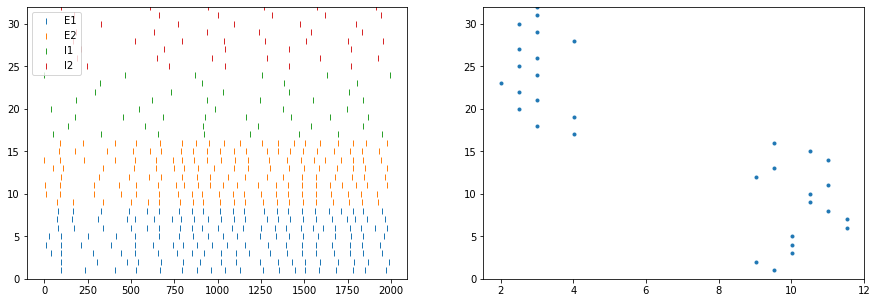

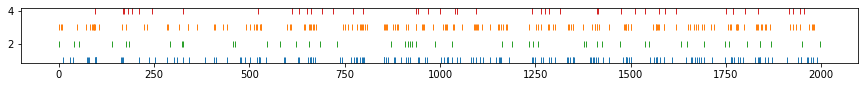

In [199]:
poisson_gen.start()
dynapse.start_graph()
dynapse.run_simulation(1)
spikes = dynapse.run_simulation(duration)
dynapse.stop_graph()
poisson_gen.stop()

spikes_array = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes_array[:,0] -= spikes_array[0,0]

exc_spikes = spikes_array[spikes_array[:,1] < 256,:]
inh_spikes = spikes_array[spikes_array[:,1] >= 256,:]
e1 = exc_spikes[exc_spikes[:,1] <= neuron_ids_E1.size,:]
e2 = exc_spikes[exc_spikes[:,1] > neuron_ids_E1.size,:]
i1 = inh_spikes[inh_spikes[:,1]-256 <= neuron_ids_I1.size,:]
i2 = inh_spikes[inh_spikes[:,1]-256 > neuron_ids_I1.size,:]

neuron_indices = np.hstack((neuron_ids_E1,neuron_ids_E2,neuron_ids_I1+256,neuron_ids_I2+256))
rates = np.array([np.count_nonzero(spikes_array[:,1] == neuron_index) for neuron_index in neuron_indices]) / (spikes_array[-1,0] - spikes_array[0,0]) * 1000000

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(e1[:,0]/1000, e1[:,1], '|', label='E1')
axs[0].plot(e2[:,0]/1000, e2[:,1], '|', label='E2')
axs[0].plot(i1[:,0]/1000, -256+2*neuron_ids_I1.size+i1[:,1], '|', label='I1')
axs[0].plot(i2[:,0]/1000, -256+2*neuron_ids_I1.size+i2[:,1], '|', label='I2')
axs[0].legend()
axs[1].plot(rates, np.arange(1,1+len(neuron_indices)), '.')
axs[0].set_ylim([0,32])
axs[1].set_ylim([0,32])
plt.show()

fig, ax = plt.subplots(1,1,figsize=(15,1))
ax.plot(e1[:,0]/1000, np.ones_like(e1[:,0]), '|', label='E1')
ax.plot(e2[:,0]/1000, 3*np.ones_like(e2[:,0]), '|', label='E2')
ax.plot(i1[:,0]/1000, 2*np.ones_like(i1[:,0]), '|', label='I1')
ax.plot(i2[:,0]/1000, 4*np.ones_like(i2[:,0]), '|', label='I2')
plt.show()